In [ ]:
!pip install torch torchvision matplotlib pillow


In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayaashraf333","key":"bb264cac9e8ab969082b68fe584cd2c2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions to secure the file

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d rightway11/state-farm-distracted-driver-detection

Dataset URL: https://www.kaggle.com/datasets/rightway11/state-farm-distracted-driver-detection
License(s): unknown
state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip state-farm-distracted-driver-detection.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/imgs/train/c6/img_86740.jpg  
  inflating: /content/dataset/imgs/train/c6/img_86769.jpg  
  inflating: /content/dataset/imgs/train/c6/img_86803.jpg  
  inflating: /content/dataset/imgs/train/c6/img_86869.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87017.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87034.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87158.jpg  
  inflating: /content/dataset/imgs/train/c6/img_8716.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87165.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87168.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87341.jpg  
  inflating: /content/dataset/imgs/train/c6/img_8736.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87360.jpg  
  inflating: /content/dataset/imgs/train/c6/img_875.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87505.jpg  
  inflating: /content/dataset/imgs/train/c6/img_87601

In [ ]:
!ls /content/dataset

driver_imgs_list.csv  imgs  sample_submission.csv


In [ ]:
import os
from PIL import Image
from torchvision import transforms

# Path to the dataset
dataset_path = "/content/dataset/imgs/test"

# List all images
images = os.listdir(dataset_path)

# Example of opening and transforming an image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = Image.open(os.path.join(dataset_path, images[0]))
img = transform(img)

print(img.shape)


torch.Size([3, 224, 224])


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())


CUDA Available: True


<ipython-input-2-8fbf71083b5a>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device(self.device)))  # Use

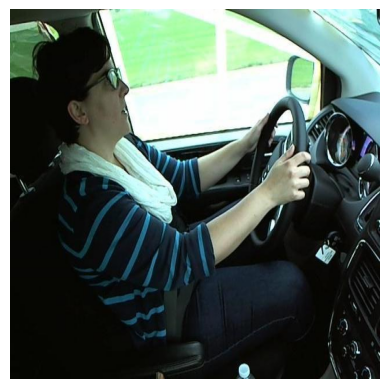

It is `Safe driving` Class with Probability 0.99%.


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Mount Google Drive for model and dataset (if needed)
#from google.colab import drive
#drive.mount('/content/drive')

# Define the PyTorch Classification Model for Inference
class PyTorchClassificationModel:
    def __init__(self, model_path, labels, transform, classes, image_size=224, device="cuda"):
        """
        Args:
            model_path: Path to the PyTorch model file (.pth)
            labels: List of label indices
            transform: Transformations to preprocess the input images
            classes: List of class names
            image_size: Size of input images
            device: 'cuda' or 'cpu'
        """
        self.device = device  # Fix: Initialize self.device first
        self.model = self.load_model(model_path, len(classes))  # Pass self.device to load_model
        self.model.eval()  # Set model to evaluation mode
        self.labels = labels
        self.image_size = image_size
        self.transform = transform
        self.classes = classes
        self.model = self.model.to(self.device)

    def load_model(self, model_path, num_classes):
        """
        Load the trained PyTorch model.
        """
        model = models.resnet18(weights=None)  # Load ResNet18 architecture
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust for the number of classes
        model.load_state_dict(torch.load(model_path, map_location=torch.device(self.device)))  # Use self.device here
        return model

    def preprocess(self, image_path):
        """
        Preprocess the input image: Resize, Normalize, and Convert to Tensor.
        """
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        image = image.unsqueeze(0)  # Add batch dimension
        return image.to(self.device)

    def run_from_filepath(self, image_path):
        """
        Perform inference on a single image from file path.
        Args:
            image_path: Path to the image
        Returns:
            Predicted class and probability
        """
        # Preprocess the image
        input_tensor = self.preprocess(image_path)

        # Perform inference
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)  # Convert logits to probabilities

        # Map probabilities to class labels
        probabilities = probabilities.cpu().numpy()
        label_to_probabilities = [
            [self.labels[i], float(probabilities[i])] for i in range(len(probabilities))
        ]
        sorted_probs = sorted(label_to_probabilities, key=lambda x: x[1], reverse=True)

        # Predicted class
        predicted_label = sorted_probs[0][0]
        predicted_probability = sorted_probs[0][1]
        predicted_class = self.classes[predicted_label]

        return predicted_class, predicted_probability


# Test the PyTorch Model
def test_pytorch_model(img_path, model_path, labels, transform, classes, device="cuda"):
    """
    Test the PyTorch classification model.
    Args:
        img_path: Path to the test image
        model_path: Path to the PyTorch model file (.pth)
        labels: List of label indices
        transform: Preprocessing transformations
        classes: List of class names
        device: 'cuda' or 'cpu'
    """
    # Initialize the model
    model = PyTorchClassificationModel(model_path, labels, transform, classes, device=device)

    # Display the input image
    imge = Image.open(img_path)
    plt.imshow(imge)
    plt.axis("off")
    plt.show()

    # Perform inference
    cls, p = model.run_from_filepath(img_path)
    print(f"It is `{cls}` Class with Probability {p:.2f}%.")


# Define the transforms for test data
test_transforms = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.CenterCrop(224),  # Crop the center
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])

# Update these paths for Google Colab
# Ensure your model and test dataset are in Google Drive or uploaded to Colab
model_path = "/content/resnet18_github.pth"  # Path to model in Google Drive
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/test_img"  # Path to test images in Google Drive

# Define class labels and names
labels = list(range(0, 10))  # Example: [0, 1, 2, ..., 9]
classes = [
    "Safe driving", "Texting - right", "Talking on the phone - right",
    "Texting - left", "Talking on the phone - left", "Operating the radio",
    "Drinking", "Reaching behind", "Hair and makeup", "Talking to passenger"
]

# Test a random image
test_image = os.path.join(test_image_dir, random.choice(os.listdir(test_image_dir)))
test_pytorch_model(test_image, model_path, labels, test_transforms, classes, device="cuda")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


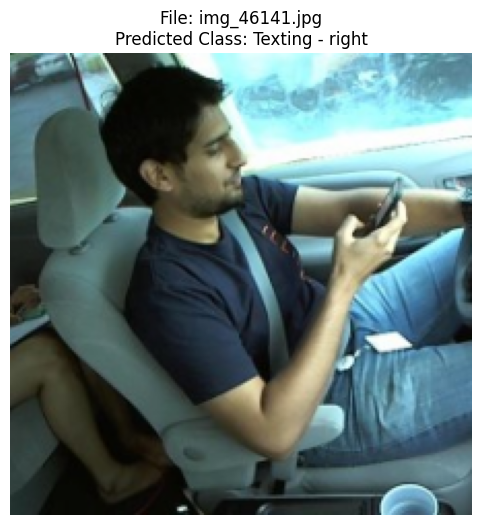

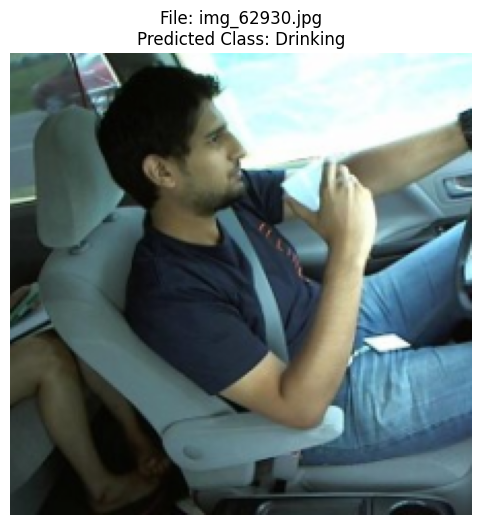

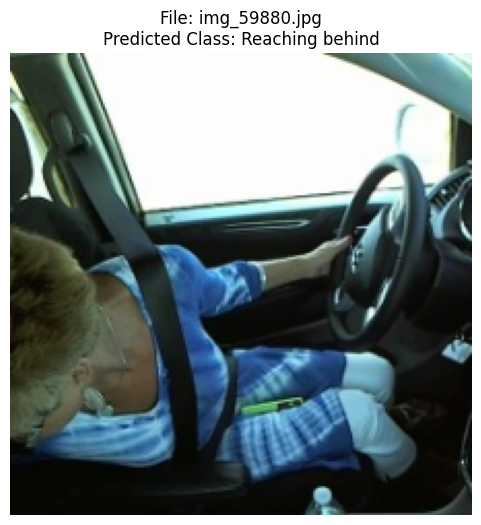

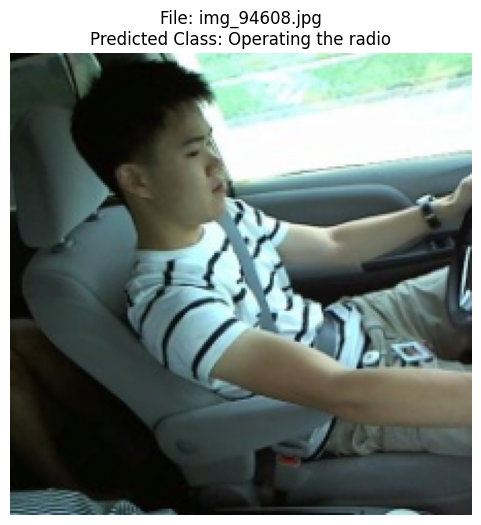

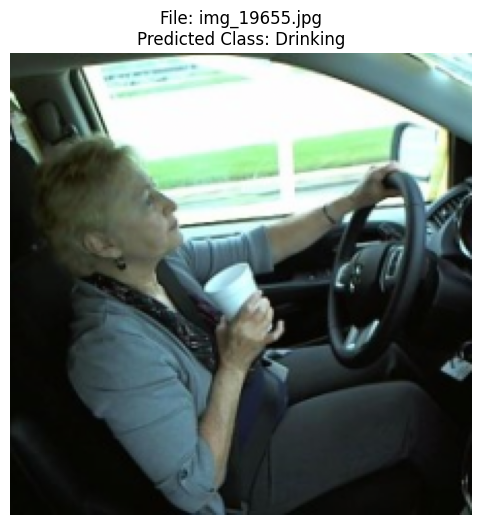

In [19]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the PyTorch Classification Model for Inference
class PyTorchClassificationModel:
    def __init__(self, model_path, labels, transform, classes, image_size=224, device="cuda"):
        """
        Args:
            model_path: Path to the PyTorch model file (.pth)
            labels: List of label indices
            transform: Transformations to preprocess the input images
            classes: List of class names
            image_size: Size of input images
            device: 'cuda' or 'cpu'
        """
        self.device = device  # Initialize device first
        self.model = self.load_model(model_path, len(classes))  # Pass self.device to load_model
        self.model.eval()  # Set model to evaluation mode
        self.labels = labels
        self.image_size = image_size
        self.transform = transform
        self.classes = classes
        self.model = self.model.to(self.device)

    def load_model(self, model_path, num_classes):
        """
        Load the trained PyTorch model.
        """
        model = models.resnet18(weights=None)  # Load ResNet18 architecture
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust for the number of classes
        model.load_state_dict(torch.load(model_path, map_location=torch.device(self.device)))  # Use self.device here
        return model

    def preprocess(self, image_path):
        """
        Preprocess the input image: Resize, Normalize, and Convert to Tensor.
        """
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        image = image.unsqueeze(0)  # Add batch dimension
        return image.to(self.device)

    def run_from_filepath(self, image_path):
        """
        Perform inference on a single image from file path.
        Args:
            image_path: Path to the image
        Returns:
            Predicted class and probability
        """
        # Preprocess the image
        input_tensor = self.preprocess(image_path)

        # Perform inference
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)  # Convert logits to probabilities

        # Map probabilities to class labels
        probabilities = probabilities.cpu().numpy()
        label_to_probabilities = [
            [self.labels[i], float(probabilities[i])] for i in range(len(probabilities))
        ]
        sorted_probs = sorted(label_to_probabilities, key=lambda x: x[1], reverse=True)

        # Predicted class
        predicted_label = sorted_probs[0][0]
        predicted_probability = sorted_probs[0][1]
        predicted_class = self.classes[predicted_label]

        return predicted_class, predicted_probability


# Define a Custom Dataset for Test Images
class CustomTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Custom dataset for loading test images.
        """
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]  # Return the image and its filename


# Function for Batch Inference
def predict_batch(data_loader, model, device, class_names, inv_transform=None):
    """
    Perform batch inference on a DataLoader of images and display predictions.
    Args:
        data_loader: DataLoader object containing the test images.
        model: PyTorch model to use for inference.
        device: 'cuda' or 'cpu'.
        class_names: List of class names for predictions.
        inv_transform: Optional transform to revert normalization for visualization.
    """
    model.eval()  # Ensure the model is in evaluation mode
    results = []  # To store predictions

    with torch.no_grad():
        for images, filenames in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class indices

            # Loop through the batch
            for i in range(images.size(0)):
                # Get the predicted class name
                predicted_class = class_names[predicted[i].item()]
                results.append((filenames[i], predicted_class))

                # Optionally visualize images
                if inv_transform:
                    # Revert normalization for visualization
                    image = inv_transform(images[i].cpu())
                    image = image.permute(1, 2, 0).numpy()

                    # Display the image with its prediction
                    plt.imshow(image)
                    plt.title(f"File: {filenames[i]}, Predicted: {predicted_class}")
                    plt.axis("off")
                    plt.show()
    return results


# Define the transforms for test data
test_transforms = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.CenterCrop(224),  # Crop the center
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])

# Define inverse transforms for visualization (optional)
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
])

# Paths and class labels
model_path = "/content/resnet18_github.pth"
test_image_dir = "/content/dataset/imgs/test"
labels = list(range(0, 10))
classes = [
    "Safe driving", "Texting - right", "Talking on the phone - right",
    "Texting - left", "Talking on the phone - left", "Operating the radio",
    "Drinking", "Reaching behind", "Hair and makeup", "Talking to passenger"
]

# Create test dataset and DataLoader
test_dataset = CustomTestDataset(test_image_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PyTorchClassificationModel(model_path, labels, test_transforms, classes, device=device).model

# # Perform batch inference
# results = predict_batch(test_loader, model, device, classes, inv_transform=inv_transform)
# print("Batch Results:")
# for file, prediction in results:
#     print(f"File: {file}, Predicted: {prediction}")

# Select a specific batch number
batch_number = 10  # For example, pick the 3rd batch (index starts from 0)

# Iterate through the DataLoader
for batch_idx, (images, filenames) in enumerate(test_loader):
    if batch_idx == batch_number:
        images = images.to(device)  # Move images to the appropriate device (GPU or CPU)
        outputs = model(images)  # Perform inference
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices

        # Display predictions for the selected batch
        for i in range(images.size(0)):
            # Get the predicted class name
            predicted_class = classes[predicted[i].item()]

            # Revert normalization for visualization
            image = inv_transform(images[i].cpu())  # Undo normalization
            image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

            # Display the image with prediction
            plt.figure(figsize=(6, 6))
            plt.imshow(image)
            plt.title(f"File: {filenames[i]}\nPredicted Class: {predicted_class}")
            plt.axis("off")
            plt.show()
        break  # Exit the loop after processing the desired batch




In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="04T5rMpgzbGLyukGMseJ")
project = rf.workspace("turki-aanj2").project("drivers-distraction-detection-oqefh")
version = project.version(1)
dataset = version.download("multiclass")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drivers'-Distraction-detection-1 in multiclass:: 100%|██████████| 2157/2157 [00:00<00:00, 4355.66it/s]
